## Importing Packages and Data

In [18]:
# Data manipulation
import pandas as pd
import numpy as np
import re

# API & data access
import json
import requests

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Color mapping for folium
from matplotlib import cm
from matplotlib.colors import Normalize, to_hex

# Interactive plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
# Pulling data from the API
dataset_id = "d_8b84c4ee58e3cfc0ece0d773c8ca6abc"
base_url = "https://data.gov.sg/api/action/datastore_search"
all_records = []
start = 0
batch_size = 100

while True:
    url = f"{base_url}?resource_id={dataset_id}&limit={batch_size}&offset={start}"
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to fetch data.")
        break

    data = response.json()
    records = data["result"]["records"]
    
    if not records:
        break  # No more data to fetch

    all_records.extend(records)
    start += batch_size

df = pd.DataFrame(all_records)

print(df['town'].unique()) # To check whether all the towns are present

['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT PANJANG'
 'BUKIT TIMAH' 'CENTRAL AREA' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG'
 'HOUGANG' 'JURONG EAST' 'JURONG WEST' 'KALLANG/WHAMPOA' 'MARINE PARADE'
 'PASIR RIS' 'PUNGGOL' 'QUEENSTOWN' 'SEMBAWANG' 'SENGKANG' 'SERANGOON'
 'TAMPINES' 'TOA PAYOH' 'WOODLANDS' 'YISHUN']


## Exploratory Data Analysis (EDA)

In [4]:
print(df.columns)
print(df.dtypes)
print(df.info())

Index(['_id', 'month', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')
_id                     int64
month                  object
town                   object
flat_type              object
block                  object
street_name            object
storey_range           object
floor_area_sqm         object
flat_model             object
lease_commence_date    object
remaining_lease        object
resale_price           object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20509 entries, 0 to 20508
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   _id                  20509 non-null  int64 
 1   month                20509 non-null  object
 2   town                 20509 non-null  object
 3   flat_type            20509 non-null  object
 4   block  

In [5]:
df.head()

,_id,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,1,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44,Improved,1979,61 years 04 months,232000
1,2,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67,New Generation,1978,60 years 07 months,250000
2,3,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67,New Generation,1980,62 years 05 months,262000
3,4,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68,New Generation,1980,62 years 01 month,265000
4,5,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67,New Generation,1980,62 years 05 months,265000


## Data Cleaning

In [6]:
# Convert column types
df['month'] = pd.to_datetime(df['month'], format='%Y-%m', errors='coerce')
df['floor_area_sqm'] = pd.to_numeric(df['floor_area_sqm'], errors='coerce')
df['resale_price'] = pd.to_numeric(df['resale_price'], errors='coerce')
df['lease_commence_date'] = pd.to_numeric(df['lease_commence_date'], errors='coerce')

In [7]:
# Check for missing values
print(df.isnull().sum())
# Drop rows with missing values
df.dropna(inplace=True)
# Check for duplicates
print(df.duplicated().sum())
# Drop duplicates
df.drop_duplicates(inplace=True)

_id                    0
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64
0


### Data Preparation for Visualisation

- Create a new dataframe with the following features for comparison
    - Flat_type
    - Average Resale Price per square metre
    - Average Number of Transactions
    - Mean Remaining Lease
    - Median Remaining Lease

In [8]:
# -------------------------------
# 1. Parse remaining lease into years
# -------------------------------
def parse_lease(lease_str):
    match = re.match(r"(\d+)\s+years\s+(\d+)\s+months", str(lease_str))
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years + months / 12
    return None

df["remaining_lease_years"] = df["remaining_lease"].apply(parse_lease)

# -------------------------------
# 2. Aggregate stats by town and flat_type
# -------------------------------
grouped = df.groupby(['town', 'flat_type'])

summary_df = grouped.agg(
    avg_resale_price=('resale_price', 'mean'),
    avg_floor_area=('floor_area_sqm', 'mean'),
    avg_transactions=('resale_price', 'count'),
    avg_remaining_lease=('remaining_lease_years', 'mean'),
    median_remaining_lease=('remaining_lease_years', 'median')
).reset_index()

# -------------------------------
# 3. Calculate avg_price_per_sqm
# -------------------------------
summary_df['avg_price_per_sqm'] = summary_df['avg_resale_price'] / summary_df['avg_floor_area']

# -------------------------------
# 4. Final tidy column order
# -------------------------------
summary_df = summary_df[[
    'town',
    'flat_type',
    'avg_resale_price',
    'avg_price_per_sqm',
    'avg_transactions',
    'avg_remaining_lease',
    'median_remaining_lease'
]]

# -------------------------------
# 5. Create flat type list per town 
#    (for lookup or mapping)
# -------------------------------
flat_types_by_town = (
    df.groupby('town')['flat_type']
    .unique()
    .apply(sorted)
    .reset_index()
    .rename(columns={'flat_type': 'available_flat_types'})
)

# Merge this into the summary for convenience
summary_df = pd.merge(summary_df, flat_types_by_town, on='town', how='left')


print("Final Summary with Available Flat Types:")
print(summary_df.head())

Final Summary with Available Flat Types:
         town  flat_type  avg_resale_price  avg_price_per_sqm  \
0  ANG MO KIO     2 ROOM     232869.565217        5271.653543   
1  ANG MO KIO     3 ROOM     315994.403071        4451.347411   
2  ANG MO KIO     4 ROOM     494595.596000        5319.147337   
3  ANG MO KIO     5 ROOM     697567.568345        5882.896008   
4  ANG MO KIO  EXECUTIVE     821000.000000        5358.230602   

   avg_transactions  avg_remaining_lease  median_remaining_lease  \
0                23            61.850000               60.541667   
1               521            62.317173               61.416667   
2               250            68.941870               61.833333   
3               139            75.947479               76.333333   
4                 9            73.583333               77.791667   

                          available_flat_types  
0  [2 ROOM, 3 ROOM, 4 ROOM, 5 ROOM, EXECUTIVE]  
1  [2 ROOM, 3 ROOM, 4 ROOM, 5 ROOM, EXECUTIVE]  
2  [2 ROOM, 

#### EDA of features

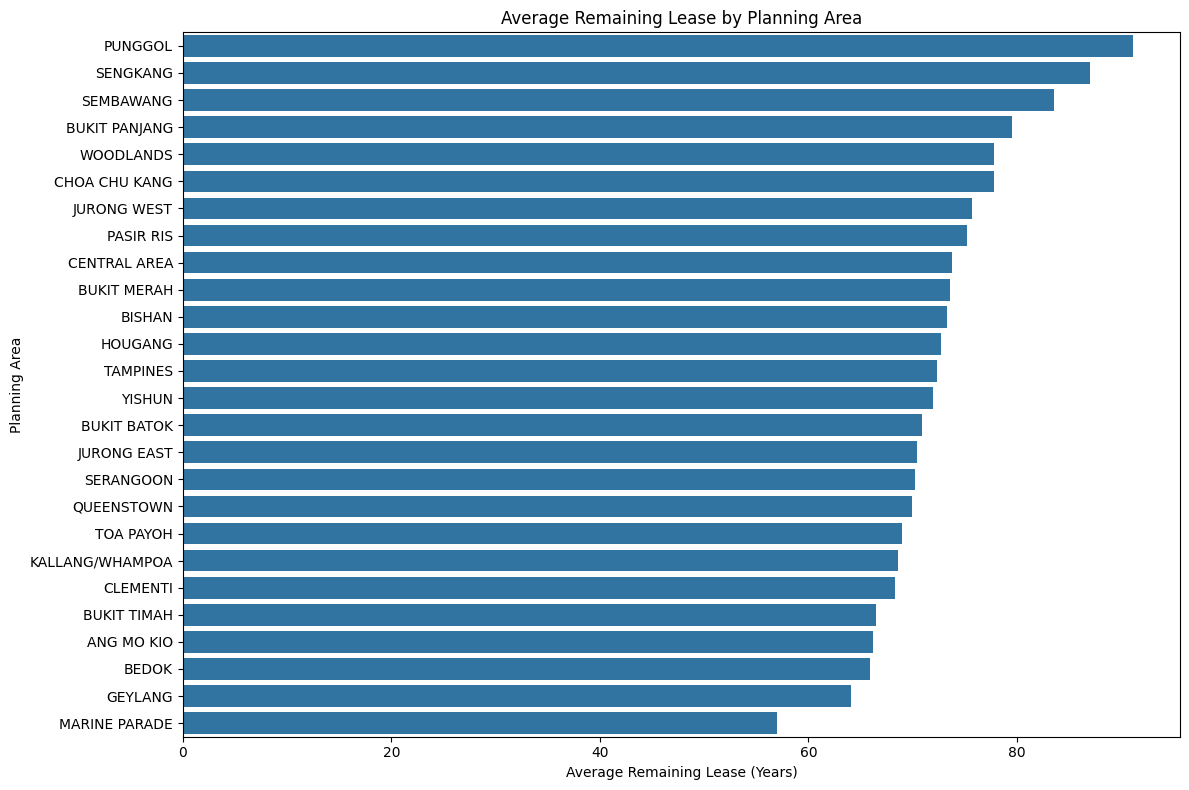

In [26]:
# Average Remaining Lease by Planning Area
lease_by_town = (
    df.groupby("town")["remaining_lease_years"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(12, 8))
sns.barplot(data=lease_by_town, y='town', x='remaining_lease_years')
plt.title("Average Remaining Lease by Planning Area")
plt.xlabel("Average Remaining Lease (Years)")
plt.ylabel("Planning Area")
plt.tight_layout()
plt.show()

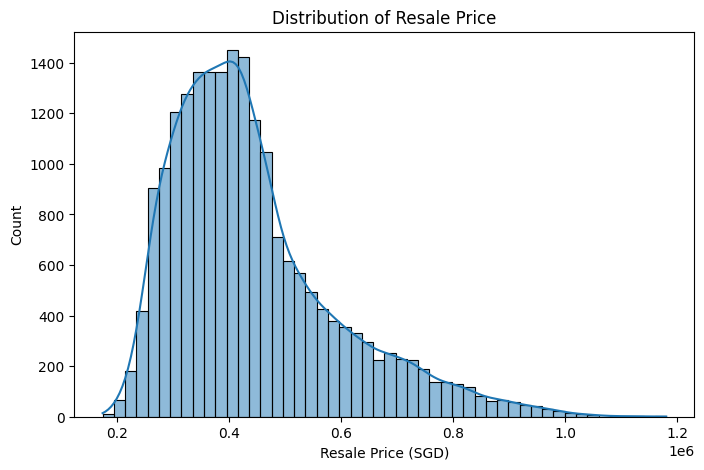

In [ ]:
# Observing the distribution of resale prices
plt.figure(figsize=(8, 5))
sns.histplot(df['resale_price'], bins=50, kde=True)
plt.title("Distribution of Resale Price")
plt.xlabel("Resale Price (SGD)")
plt.ylabel("Count")
plt.show()


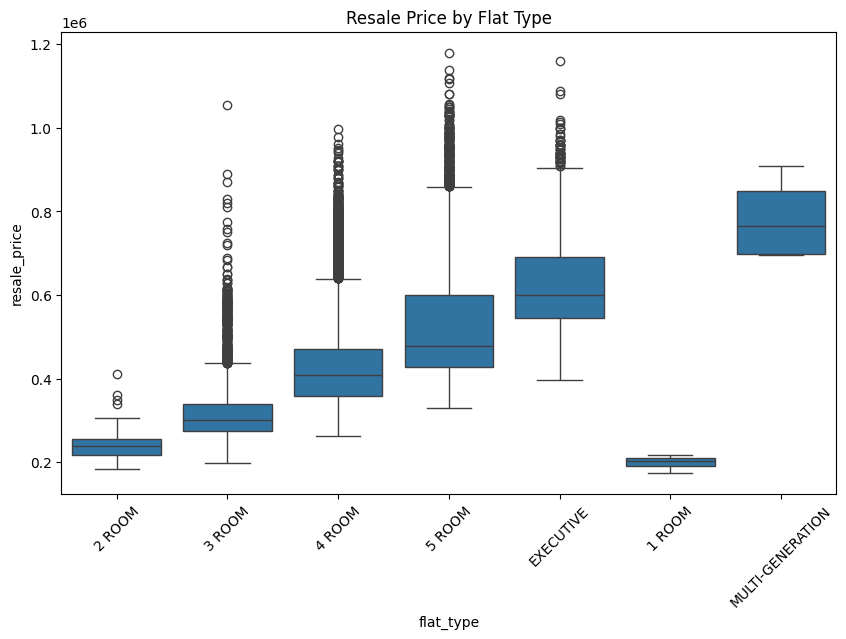

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='flat_type', y='resale_price')
plt.title("Resale Price by Flat Type")
plt.xticks(rotation=45)
plt.show()


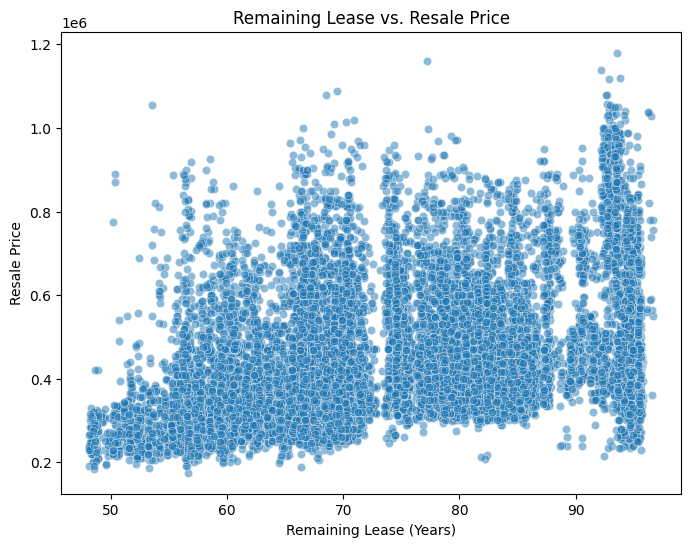

In [ ]:
# Relationship between remaining lease and resale price
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='remaining_lease_years', y='resale_price', alpha=0.5)
plt.title("Remaining Lease vs. Resale Price")
plt.xlabel("Remaining Lease (Years)")
plt.ylabel("Resale Price")
plt.show()


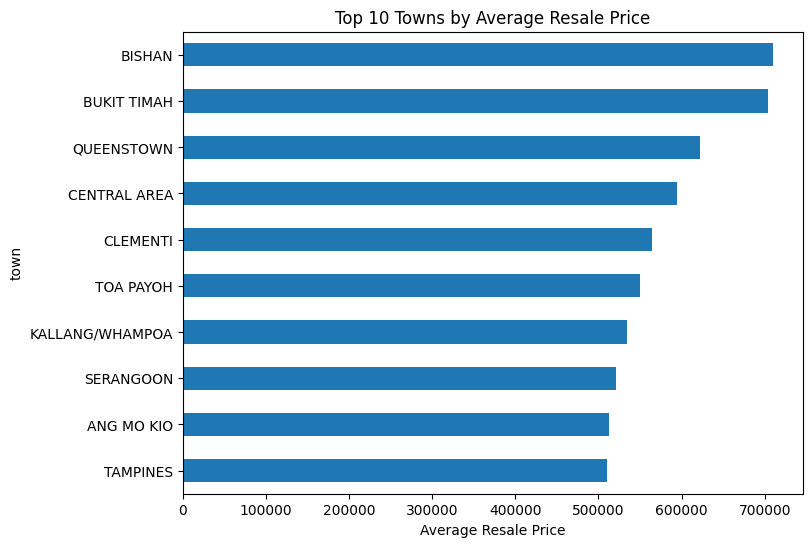

In [ ]:
# Top 10 towns by average resale price
top_towns = (
    summary_df.groupby('town')['avg_resale_price']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

top_towns.plot(kind='barh', figsize=(8, 6), title='Top 10 Towns by Average Resale Price')
plt.xlabel("Average Resale Price")
plt.gca().invert_yaxis()
plt.show()


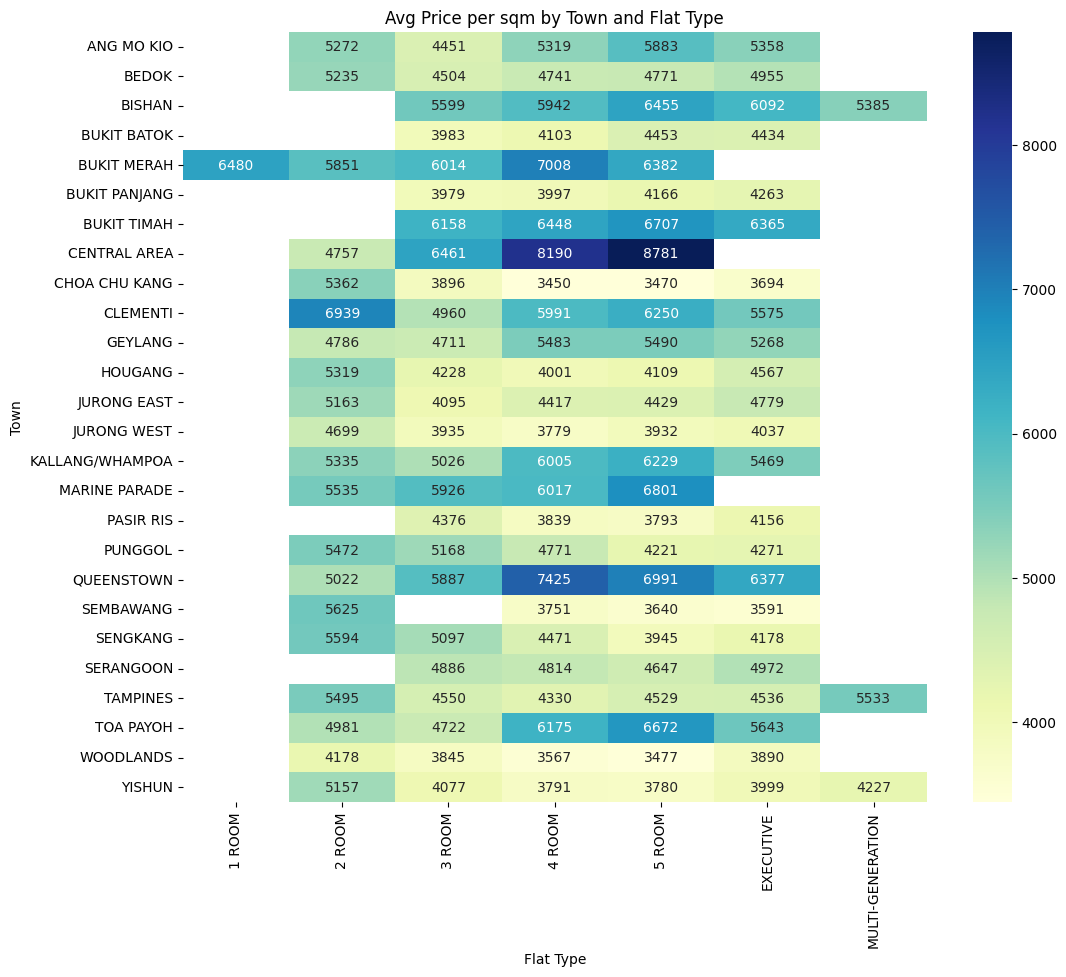

In [ ]:
# Visualizing average price per sqm by town and flat type
pivot = summary_df.pivot(index='town', columns='flat_type', values='avg_price_per_sqm')

plt.figure(figsize=(12, 10))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Avg Price per sqm by Town and Flat Type")
plt.xlabel("Flat Type")
plt.ylabel("Town")
plt.show()


- Obtaining town coordinates (manually copied)

In [9]:
town_coordinates = {
    'ANG MO KIO': (1.3691, 103.8454),
    'BEDOK': (1.3244, 103.9301),
    'BISHAN': (1.3509, 103.8485),
    'BUKIT BATOK': (1.3496, 103.7499),
    'BUKIT MERAH': (1.2777, 103.8203),
    'BUKIT PANJANG': (1.3784, 103.7633),
    'BUKIT TIMAH': (1.3294, 103.8021),
    'CENTRAL AREA': (1.2905, 103.8510),
    'CHOA CHU KANG': (1.3854, 103.7449),
    'CLEMENTI': (1.3151, 103.7655),
    'GEYLANG': (1.3160, 103.8855),
    'HOUGANG': (1.3711, 103.8922),
    'JURONG EAST': (1.3321, 103.7430),
    'JURONG WEST': (1.3400, 103.7064),
    'KALLANG/WHAMPOA': (1.3210, 103.8618),
    'MARINE PARADE': (1.3032, 103.9057),
    'PASIR RIS': (1.3730, 103.9497),
    'PUNGGOL': (1.4043, 103.9021),
    'QUEENSTOWN': (1.2944, 103.8031),
    'SEMBAWANG': (1.4491, 103.8205),
    'SENGKANG': (1.3911, 103.8950),
    'SERANGOON': (1.3496, 103.8739),
    'TAMPINES': (1.3496, 103.9568),
    'TOA PAYOH': (1.3343, 103.8518),
    'WOODLANDS': (1.4360, 103.7865),
    'YISHUN': (1.4294, 103.8350)
}


## Questions of Contention

### Question 1: Which areas are high in demand in Singapore, based on resale prices?


### Visualisation using plotly
#### Features of Map
- Size of Circle Markers -> Average Number of Transactions
- Colour Intensity of Circle Markers -> Average Price per sqm

In [19]:
# -----------------------------
# 1. Map coordinates to towns
# -----------------------------
summary_df["lat"] = summary_df["town"].map(lambda t: town_coordinates.get(t, (None, None))[0])
summary_df["lon"] = summary_df["town"].map(lambda t: town_coordinates.get(t, (None, None))[1])

# -----------------------------
# 2. Identify towns missing coordinates
# -----------------------------
missing = summary_df.loc[
    summary_df["lat"].isna() | summary_df["lon"].isna(), "town"
].unique()

if len(missing) > 0:
    print("Missing coordinates for the following towns (not shown on map):")
    for t in missing:
        print(" -", t)

# -----------------------------
# 3. Drop rows with missing coordinates and reset index
# -----------------------------
summary_df = summary_df.dropna(subset=["lat", "lon"]).reset_index(drop=True)

# -----------------------------
# 4. Scale circle radius by transaction count
# -----------------------------
max_tx = summary_df["avg_transactions"].max()
min_radius = 5    # Minimum marker size
max_radius = 25   # Maximum marker size

# -----------------------------
# 5. Color map normalization based on price per sqm
# -----------------------------
norm = Normalize(
    vmin=summary_df["avg_price_per_sqm"].min(),
    vmax=summary_df["avg_price_per_sqm"].max()
)
colors = [to_hex(cm.YlOrRd(norm(v))) for v in summary_df["avg_price_per_sqm"]]

# -----------------------------
# 6. Create base map centered on Singapore
# -----------------------------
m = folium.Map(location=[1.3521, 103.8198], zoom_start=11)

# -----------------------------
# 7. Add circle markers with detailed HTML popups
# -----------------------------
for idx, row in summary_df.iterrows():
    # Compute proportional radius
    radius = min_radius + (row["avg_transactions"] / max_tx) * (max_radius - min_radius)

    # Format HTML popup content
    html_popup = folium.Popup(
        f"<b>{row['town']}</b><br>"
        f"Avg Resale Price: {row['avg_price_per_sqm']:.2f} SGD/sqm<br>"
        f"Avg Transactions: {int(row['avg_transactions'])}<br>"
        f"Avg Remaining Lease: {row['avg_remaining_lease']:.1f} years<br>"
        f"Median Remaining Lease: {row['median_remaining_lease']:.1f} years <br>"
        f"Room Types: {row['available_flat_types']}<br>",
        max_width=250
    )

    # Add circle marker to the map
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=radius,
        popup=html_popup,
        color=colors[idx],
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# -----------------------------
# 8. Save map to HTML file
# -----------------------------
m.save("hdb_demand_map.html")

# Displaying map inline
m


#### Findings

According to the Law of Demand, 

### Question 2: How has housing prices changed over time for the same housing type and area?

Aims:

- To prepare data for to visualise how prices have changed. 

- Can go from Town, to Flat Type within the town

- Point out some anomalies too

In [13]:

# -------------------------------
# 1. Group by flat_type and month, compute median resale price per sqm
# -------------------------------
room_median_df = df.groupby(['flat_type', 'month']).agg(
    median_price_per_sqm=('resale_price', lambda x: x.median() / df['floor_area_sqm'].median())
).reset_index()

# -------------------------------
# 2. Convert 'month' to datetime
# -------------------------------
room_median_df['month'] = pd.to_datetime(room_median_df['month'], format='%Y-%m', errors='coerce')

# -------------------------------
# 3. Drop any invalid or missing rows
# -------------------------------
room_median_df = room_median_df.dropna(subset=['month', 'median_price_per_sqm'])

# -------------------------------
# 4. Create interactive line chart using Plotly
# -------------------------------
fig = px.line(
    room_median_df,
    x='month',
    y='median_price_per_sqm',
    color='flat_type',
    markers=True,
    title='Median Resale Price per sqm Over Time (Aggregated Across Towns)',
    labels={
        'month': 'Year',
        'median_price_per_sqm': 'Median Price per sqm (SGD)',
        'flat_type': 'Flat Type'
    }
)
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Median Price per sqm (SGD)',
    legend_title='Flat Type',
    template='plotly_white'
)
fig.update_traces(mode='lines+markers', line=dict(width=2))



fig.show()


### Data Preparation

In [ ]:
# -------------------------------
# 1. Group by town, flat type, and month
# -------------------------------
room_price_df = df.groupby(['town', 'flat_type', 'month']).agg(
    avg_price_per_sqm=('resale_price', lambda x: x.mean() / df['floor_area_sqm'].mean()),
    avg_transactions=('resale_price', 'count'),
    avg_remaining_lease=('lease_commence_date', lambda x: 2023 - x.mean()),
    median_remaining_lease=('lease_commence_date', lambda x: 2023 - x.median())
).reset_index()

# -------------------------------
# 2. Pivot and melt to long format
# -------------------------------
room_price_pivot = room_price_df.pivot_table(
    index=['town', 'flat_type'],
    columns='month',
    values='avg_price_per_sqm',
    fill_value=0
).reset_index()

room_price_long = room_price_pivot.melt(
    id_vars=['town', 'flat_type'],
    var_name='month',
    value_name='avg_price_per_sqm'
)

# -------------------------------
# 3. Convert 'month' to datetime
# -------------------------------
room_price_long['month'] = pd.to_datetime(room_price_long['month'], format='%Y-%m', errors='coerce')

# -------------------------------
# 4. Drop rows with no transactions
# -------------------------------
room_price_long = room_price_long[room_price_long['avg_price_per_sqm'] > 0]

# -------------------------------
# 5. Set up towns and flat types
# -------------------------------
towns = sorted(room_price_long['town'].unique())
flat_types = sorted(room_price_long['flat_type'].unique())

# Define consistent colors for each flat type
flat_type_colors = {
    "1 ROOM": "#1f77b4",       # Blue
    "2 ROOM": "#636EFA",       # Indigo
    "3 ROOM": "#EF553B",       # Red
    "4 ROOM": "#00CC96",       # Green
    "5 ROOM": "#AB63FA",       # Purple
    "EXECUTIVE": "#FFA15A",    # Orange
    "MULTI-GENERATION": "#19D3F3",  # Cyan
}


flat_types = sorted(room_price_long['flat_type'].unique())
color_palette = px.colors.qualitative.Set2  # or 'Plotly', 'Dark24', etc.

# Map flat types to a color (repeating if needed)
flat_type_colors = {ft: color_palette[i % len(color_palette)] for i, ft in enumerate(flat_types)}


# Split towns into 3 groups
n_groups = 3
batches = [towns[i::n_groups] for i in range(n_groups)]

# -------------------------------
# 6. Loop through each batch of towns to create subplots
# -------------------------------
for batch_num, town_batch in enumerate(batches, start=1):
    n_cols = 3
    n_rows = -(-len(town_batch) // n_cols)  # Ceiling division

    fig = make_subplots(
        rows=n_rows,
        cols=n_cols,
        subplot_titles=town_batch,
        shared_xaxes=True,
        shared_yaxes=True,
        horizontal_spacing=0.05,
        vertical_spacing=0.1
    )

    row, col = 1, 1
    shown_flat_types = set()

    for town in town_batch:
        town_data = room_price_long[room_price_long['town'] == town]

        for flat_type in flat_types:
            flat_data = town_data[town_data['flat_type'] == flat_type]
            if flat_data.empty:
                continue

            fig.add_trace(
                go.Scatter(
                    x=flat_data['month'],
                    y=flat_data['avg_price_per_sqm'],
                    mode='lines+markers',
                    name=flat_type,
                    legendgroup=flat_type,
                    showlegend=(flat_type not in shown_flat_types),
                    line=dict(color=flat_type_colors[flat_type])
                ),
                row=row,
                col=col
            )
            shown_flat_types.add(flat_type)

        # Advance subplot position
        if col < n_cols:
            col += 1
        else:
            col = 1
            row += 1

    # -------------------------------
    # 7. Update layout and show
    # -------------------------------
    fig.update_layout(
        height=n_rows * 350,
        width=1200,
        title_text=f"HDB Resale Price Trends per sqm — Town Group {batch_num}",
        showlegend=True,
        template="plotly_white"
    )

    fig.update_xaxes(title_text="Month", tickangle=45)
    fig.update_yaxes(title_text="Avg Price per sqm (SGD)")

    fig.show()
    # Optional: Save to HTML
    # fig.write_html(f"price_trends_group_{batch_num}.html")


## Question 3: How will housing prices change in years' to come?

Aim:
- Train test split for selected planning areas 
    - Newer Estates (i.e regions that have higher median lease): Punggol, Sengkang
    - Older Estates (i.e regions that have lower median lease): Marine Parade, Geylang